In [1]:
import numpy as np
import matplotlib
#import seaborn as sns
from matplotlib import pyplot as plt
import os
import sys

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
module_path = os.path.abspath(os.path.join('../..'))

In [5]:
from ariadne.parsing import parse_df
import ariadne.transformations  as trn

In [6]:
from prepare import parse

In [7]:
!ls ../lightning_logs/TrackNETv2

version_0  version_10  version_3  version_5  version_7	version_9
version_1  version_2   version_4  version_6  version_8


In [8]:
elem = '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/ariadne/data/bmn_data/bmn_5.txt'
csv_params={
                    "sep": '\s+',
                    #"nrows": 500000,
                    "encoding": 'utf-8',
                    "names":  ['event',  'x', 'y', 'z', 'det','station', 'track', 'px', 'py', 'pz', 'vx', 'vy', 'vz']
                 }
df = parse_df(elem, **csv_params)
#sns.set_style('darkgrid')
grouped_df = df.groupby('event')
num_hits = []
num_tracks = []
num_fakes = []
one_event = None
num = 163

In [9]:
from mpl_toolkits.mplot3d import Axes3D

In [10]:
#for i, ev_data in grouped_df:
#    if i > 0:
#        break
#    stations = ev_data.groupby('station').size().max()
#    #max_station = max(stations)
#    num_hits.append(stations)
#    num_fakes.append(len(ev_data[ev_data['track']==-1]))
#    num_tracks.append(ev_data[ev_data['track']!=-1].groupby('track').ngroups)
#max_num_hits = []
#num_events = []
#for i in range(1, len(num_hits)):
#    max_num_hits.append(np.max(num_hits[:i]))
#    num_events.append(i)

In [11]:
z_values = {0:12.344, 1: 15.614, 2: 24.499, 3: 39.702, 4: 64.535, 5: 112.649, 6: 135.330,7: 160.6635, 8: 183.668}

In [12]:
transformer = trn.Compose([
    trn.DropShort(num_stations=4),
    trn.DropTracksWithHoles(),
    trn.DropSpinningTracks(),
    #@DropFakes(),
    trn.BakeStationValues(values=z_values),]
    #@ToCylindrical(),
    #@ConstraintsNormalize(),
   # @ToBuckets(),
)

#transformed = transformer(one_event)

In [13]:
from ariadne.utils.model import get_checkpoint_path, weights_update
from ariadne.tracknet_v2.model import TrackNETv2
from ariadne.tracknet_v2_1.model import TrackNetClassifier

In [14]:
tracknet_input_features=3
tracknet_conv_features=32
DEVICE='cpu'

In [15]:
import torch

tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/d/drusov/ariadne/lightning_logs/TrackNETv2', 
                           'version': 'version_10', 'checkpoint': 'latest'}
#classifier_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNetClassifier', 
#                             'version': 'version_108', 'checkpoint': 'latest'}

In [16]:
path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)
#path_to_classifier_ckpt = get_checkpoint_path(**classifier_ckpt_path_dict)

model = weights_update(model=TrackNETv2(input_features=tracknet_input_features,
                                        conv_features=tracknet_conv_features,
                                        rnn_type='gru',
                                        batch_first=True,
                                        use_causalconv=True),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
model.eval()

TrackNETv2(
  (conv): Sequential(
    (0): CausalConv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(2,), bias=False)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rnn): GRU(32, 32, num_layers=2, batch_first=True)
  (xy_coords): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
  (r1_r2): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [17]:
model.to(DEVICE)

TrackNETv2(
  (conv): Sequential(
    (0): CausalConv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(2,), bias=False)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rnn): GRU(32, 32, num_layers=2, batch_first=True)
  (xy_coords): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
  (r1_r2): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [18]:
from ariadne.utils.data import load_data
from ariadne.utils.base import store_in_index,search_in_index
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropSpinningTracks, DropShort

In [19]:
from ariadne.utils.base import *
from ariadne.utils.inference import *

In [20]:
import itertools

def get_seeds(hits, columns=['x','y','z']):
    temp1 = hits[hits.station == 0]
    st0_hits = hits[hits.station == 0][columns].values
    temp2 = hits[hits.station == 1]
    st1_hits = hits[hits.station == 1][columns].values
    # all possible combinations
    idx0 = range(len(st0_hits))
    idx1 = range(len(st1_hits))
    idx_comb = itertools.product(idx0, idx1)
    # unpack indices
    idx0, idx1 = zip(*idx_comb)
    idx0 = list(idx0)
    idx1 = list(idx1)
    # create seeds array
    seeds = np.zeros((len(idx0), 2, 3))
    seeds[:, 0, ] = st0_hits[idx0]
    seeds[:, 1, ] = st1_hits[idx1]
    return seeds

In [21]:
_columns=('x', 'y', 'z')

In [22]:
def filter_hits_in_ellipses(ellipses, nearest_hits, hits_index, z_last=True, filter_station=True, find_n=10):
    """Function to get hits, which are in given ellipse.
    Space is 3-dimentional, so either first component of ellipce must be z-coordinate or third.
    Ellipse semiaxises must include x- and y-axis.
    Arguments:
        ellipse (np.array of size 5): predicted index with z-component like
                                      (x,y,z, x-semiaxis, y_semiaxis) or (z, x,y, x-semiaxis, y_semiaxis)
        nearest_hits (np.array of shape (n_hits, 3) or only 3): some hits in 3-dim space
        z_last (bool): If True, first component of vector is interpreted as z, if other, third.
        filter_station (bool): if True, only hits with same z-coordinate are considered, else all hits
    Returns:
        numpy.ndarry with filtered hits, all of them in given ellipse, sorted by increasing of distance
    """
    assert nearest_hits.shape[-1] == 3, "index is 3-dimentional, please add z-coordinate to centers"
    if nearest_hits.ndim < 2:
        nearest_hits = np.expand_dims(nearest_hits, 0)
    if nearest_hits.ndim < 3:
        nearest_hits = np.expand_dims(nearest_hits, 0)
    assert ellipses.shape[-1] == 5, "index is 3-dimentional, you need to provide z-coordinate (z_c, x_c, y_c, x_r, y_r) or (x_c, y_c, z_c, x_r, y_r)"
    #ellipses = np.expand_dims(ellipses, -1)
    #find_n = len(nearest_hits)
    ellipses = np.expand_dims(ellipses, 2)
    #found_hits = nearest_hits.reshape(-1, find_n, nearest_hits.shape[-1])
    if z_last:
        x_part = (ellipses[:,0].repeat(find_n,1) - nearest_hits[:, :, 0]) / ellipses[:, 3].repeat(find_n,1)
        #print(x_part**2)
        y_part = (ellipses[:,1].repeat(find_n,1) - nearest_hits[:, :, 1]) / ellipses[:, 4].repeat(find_n,1)
        #print(y_part**2)
    else:
        x_part = (nearest_hits[:, :, 1] - ellipses[:, 1].repeat(find_n, 1)) / ellipses[:, -2].repeat(find_n, 1)
        y_part = (nearest_hits[:, :, 2] - ellipses[:, 2].repeat(find_n, 1)) / ellipses[:, -1].repeat(find_n, 1)
    left_side = x_part**2 + y_part**2
    is_in_ellipse = left_side <= 1
    is_in_ellipse *= hits_index != -1
    return nearest_hits, is_in_ellipse

In [23]:
NUM_COMPONENTS = 2
SUFX = ['_p', '_c']
COLS = ['x', 'y', 'z']

def build_index(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return store_in_index(cont)

def build_hits(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return cont

def search(points, index):
    cont = np.ascontiguousarray(points[COLS].values)
    return search_in_index(cont, index, 10, n_dim=3)

def to_cart(df):
    graph=to_pandas_graph_from_df(df,SUFX, save_index=False)
    seeds = graph[(graph.station_p == 0) & (graph.station_c == 1)]
    target = df[df.station == 2]
    return seeds, target

def seeds_to_input(seeds_df):
    return seeds_df[['x_p', 'y_p', 'z_p', 'x_c', 'y_c', 'z_c']].values.reshape((-1, 2, 3))

def process_one_event(event_df):
    event_df.loc[event_df["det"] == 1, 'station'] = event_df.loc[event_df["det"] == 1, 'station'].values + 3
    event_df = event_df[['event','x','y','z','station','track']]
    
    try:
        event_df = transformer(event_df)
    except AssertionError as err:
        print("ASS error %r" % err)
        return None
    event_df.rename(columns={'index': 'index_old'}, inplace=True)
    
    preds, labels, ellipses = go_over_stations(event_df, max_n_stations=9)
    return preds, ellipses, labels, event_df

def process_one_event_no_trans(event_df):
    event_df = event_df[['event','x','y','z','station','track', 'index_old']]

    preds, labels, ellipses = go_over_stations(event_df, max_n_stations=9)
    return preds, ellipses, labels, event_df
    #return seeds, target

In [24]:
def get_data_for_empty_ellipses(x, preds, grus, mask):
    empty_ellipses_mask = (mask.sum(axis=-1) == 0) # if nothing is found in ellipse
    empty_ellipses = preds[empty_ellipses_mask]#.detach().cpu().numpy()
    full_ellipses = preds[~empty_ellipses_mask]
    empty_xs = x[empty_ellipses_mask]
    empty_grus = grus[empty_ellipses_mask]#.detach().cpu().numpy()
    return empty_xs, empty_ellipses, empty_grus, full_ellipses

In [25]:
import gin

In [26]:
gin.enter_interactive_mode()

In [27]:
def get_tracks(df, min_len=4):
    tracks = df[df['track'] != -1].groupby('track')
    multiplicity = tracks.ngroups
    tracks_vs_len = {3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
    all_tracks = []
    for i, track in tracks:
        temp_track = track[['x', 'y', 'z']].values
        if len(temp_track) >= min_len:
            tracks_vs_len[len(temp_track)].append(temp_track)
            all_tracks.append(temp_track)
    for stations_in_track, this_track_list in tracks_vs_len.items():
        if len(this_track_list) > 0:
            tracks_vs_len[stations_in_track] = np.stack(this_track_list, 0)
    return tracks_vs_len, all_tracks, multiplicity

In [28]:
def get_labels(gt_tracks, predicted_tracks, use_torch=False, device='cuda'):
    if use_torch:
        labels_for_ellipses = torch.zeros(len(predicted_tracks), dtype=torch.bool, device=device)
        assert len(predicted_tracks) > 0, 'Can not compute labels for empty set of tracks!'
        if len(gt_tracks) > 0:
            expanded_tracks = gt_tracks.unsqueeze(0).repeat((len(predicted_tracks), 1, 1, 1))
            expanded_xs = predicted_tracks.unsqueeze(1).repeat((1, expanded_tracks.shape[1], 1,1))
            labels_for_ellipses += torch.any(torch.all(torch.all(torch.isclose(expanded_tracks.float(), expanded_xs.float().to(device), rtol=1e-04 ), dim=-1), dim=-1),
                                             dim=-1)
            assert len(labels_for_ellipses) == len(expanded_xs), 'length of labels and xs is different!'
        labels_for_ellipses_numpy = labels_for_ellipses.detach().cpu().numpy()
        del labels_for_ellipses
        return labels_for_ellipses_numpy
    else:
        labels_for_ellipses = np.zeros(len(predicted_tracks), dtype=bool)
        assert len(predicted_tracks) > 0, 'Can not compute labels for empty set of tracks!'
        if len(gt_tracks) > 0:
            expanded_tracks = np.expand_dims(gt_tracks, 0).repeat(len(predicted_tracks), 0)
            expanded_xs = np.expand_dims(predicted_tracks, 1).repeat(expanded_tracks.shape[1], 1)
            labels_for_ellipses += np.any(
                np.all(np.all(np.equal(expanded_tracks, expanded_xs), axis=-1),
                       axis=-1), axis=-1)
            assert len(labels_for_ellipses) == len(expanded_xs), 'length of labels and xs is different!'
    return labels_for_ellipses

In [29]:
def prolong(x, gru, nearest_hits_mask, nearest_hits, stations_gone, use_torch=False):
    if use_torch:
        xs_for_prolong = x.unsqueeze(1).repeat((1, nearest_hits_mask.shape[-1], 1,1))
        grus_for_prolong = gru.unsqueeze(1)
        grus_for_prolong = grus_for_prolong.repeat((1, nearest_hits_mask.shape[-1], 1))
        prolonged_xs = torch.zeros((len(xs_for_prolong),
                                    nearest_hits_mask.shape[-1],
                                    xs_for_prolong.shape[-2] + 1,
                                    xs_for_prolong.shape[-1]))
        prolonged_xs[:, :, :xs_for_prolong.shape[-2], :] = xs_for_prolong
        prolonged_xs[:, :, xs_for_prolong.shape[-2], :] = nearest_hits
        #print(prolonged_xs.shape)
        prolonged_xs = prolonged_xs.reshape(-1, stations_gone + 1, 3)
        nearest_hits_mask = nearest_hits_mask.reshape(-1)
        prolonged_xs = prolonged_xs[nearest_hits_mask]
        prolonged_grus = grus_for_prolong.reshape(-1, grus_for_prolong.shape[-1])
        prolonged_grus = prolonged_grus[nearest_hits_mask]
    else:
        xs_for_prolong = np.expand_dims(x, 1).repeat(nearest_hits_mask.shape[-1], 1)
        grus_for_prolong = np.expand_dims(gru.detach().cpu().numpy(), 1).repeat(nearest_hits_mask.shape[-1], 1)
        prolonged_xs = np.zeros(
            (len(xs_for_prolong), nearest_hits_mask.shape[-1], xs_for_prolong.shape[2] + 1, 3))

        prolonged_xs[:, :, :xs_for_prolong.shape[2], :] = xs_for_prolong
        prolonged_xs[:, :, xs_for_prolong.shape[2], :] = nearest_hits
        prolonged_xs = prolonged_xs[nearest_hits_mask].reshape(-1, stations_gone + 1, 3)
        prolonged_grus = grus_for_prolong[nearest_hits_mask].reshape(-1,
                                                                     grus_for_prolong.shape[-2],
                                                                     grus_for_prolong.shape[-1])
    return prolonged_xs, prolonged_grus

In [30]:
def get_labels_faiss(gt_tracks, predicted_tracks, index):
    labels_for_ellipses = np.zeros(len(predicted_tracks))
    assert len(predicted_tracks) > 0, 'Can not compute labels for empty set of tracks!'
    if len(gt_tracks) > 0:
        tracks_len = gt_tracks.shape[-2]
        gt_tracks = gt_tracks.reshape(-1, gt_tracks.shape[-1])
        predicted_tracks = predicted_tracks.reshape(-1, gt_tracks.shape[-1])
        gt_index = search_in_index(gt_tracks, index, 1, n_dim=3).flatten().reshape(-1, tracks_len)
        predicted_index = search_in_index(predicted_tracks, index, 1, n_dim=3).flatten().reshape(-1, tracks_len)
        expanded_gt = np.expand_dims(gt_index, 0).repeat(len(predicted_index), 0)
        expanded_preds = np.expand_dims(predicted_index, 1).repeat(expanded_gt.shape[1], 1)
        labels_for_ellipses += np.any(np.all(np.equal(expanded_gt, expanded_preds), axis=-1),axis=-1)
        assert len(labels_for_ellipses) == len(expanded_preds), 'length of labels and xs is different!'
    return labels_for_ellipses

In [31]:
def get_candidates(preds, targets, grus, ellipses, index, labels,  labels_for_batch, gru_candidates, track_candidates, candidate_ellipses):
    orig_ellipses = torch.zeros((len(ellipses), 4))
    orig_ellipses[:, :2] = ellipses[:, :2]
    orig_ellipses[:, 2:] = ellipses[:, 3:]
    labels_for_ellipses = get_labels_faiss(targets,
                                     preds.detach().cpu().numpy(), index=index)
    labels_for_batch.append(labels_for_ellipses)
    gru_candidates.extend(grus)  # because we need gru for predicted ellipse
    labels.extend(labels_for_ellipses)
    track_candidates.extend(preds)
    candidate_ellipses.extend(orig_ellipses)
    return labels, labels_for_batch, gru_candidates, track_candidates, candidate_ellipses

In [32]:
def get_seeds_only_real(df, columns=['x','y','z']):
    real = df[df['track']!=-1]
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    temp2 = real[real.station == 1]
    st1_hits = temp2[columns].values
    # all possible combinations
    seeds = np.zeros((len(temp1), 2, 3))
    seeds[:, 0, ] = st0_hits
    seeds[:, 1, ] = st1_hits
    return seeds

In [33]:
def get_seeds_only_real_one_hit(df, columns=['x','y','z']):
    real = df[df['track']!=-1]
    temp1 = real[real.station == 0]
    st0_hits = temp1[columns].values
    #temp2 = real[real.station == 1]
    #st1_hits = temp2[columns].values
    # all possible combinations
    seeds = np.zeros((len(temp1), 1, 3))
    seeds[:, 0, ] = st0_hits
    #seeds[:, 1, ] = st1_hits
    #print('seeds:', seeds)
    return seeds

In [34]:
def go_over_stations(df, max_n_stations=9):
    max_batch_size = 256
    all_hits_index = build_index(df)
    tracks_vs_len, all_tracks, multiplicity = get_tracks(df)
    #print(tracks_vs_len)
    #seeds, target = to_cart(df)
    chunk_data_x = get_seeds_only_real(df)
    #print(chunk_data_x)
    #chunk_data_x = np.expand_dims(chunk_data_x, 1)
    #index = build_index(target)
    # search(target[:2], index)
    #chunk_data_x = seeds_to_input(seeds)
    chunk_data_len = torch.tensor(np.full(len(chunk_data_x), 2), dtype=torch.int64).to(DEVICE)
    gru_candidates = []
    x_candidates = []
    candidate_labels = []
    candidate_ellipses = []
    for stations_gone in range(2, max_n_stations):
        #print(f'===> {stations_gone}')
        num_batches = int(len(chunk_data_x) / max_batch_size) + 1
        #print(num_batches)
        num_right_batches = 0
        num_all_batches = 0
        next_stage_xs = []
        next_stage_lens = []
        if len(chunk_data_x) == 0:
            #print('Have zero ellipces on this station! Skipping other stations')
            #print(candidate_ellipses)
            #print(x_candidates)
            #print(candidate_labels)
            return x_candidates, candidate_labels, candidate_ellipses
        labels_for_empty_el_batch = []
        labels_for_full_el_batch = []
        station_df = df[df['station']==stations_gone]
        current_index = build_index(station_df)
        this_station_hits = build_hits(station_df)
        for batch_num in range(num_batches):
            min_i = max_batch_size*batch_num
            max_i = min(max_batch_size + min_i, len(chunk_data_x))
            if min_i==max_i:
                #print('Have zero ellipces on this station! Skipping other stations')
                #print(candidate_ellipses)
                #print(x_candidates)
                #print(candidate_labels)
                return x_candidates, candidate_labels, candidate_ellipses
            
            this_batch_x = torch.tensor(chunk_data_x[min_i: max_i]).to(DEVICE)
            this_batch_len = chunk_data_len[min_i: max_i]
            #print(this_batch_x)
            batch_prediction, batch_gru = model(this_batch_x,
                                                     torch.tensor(this_batch_len, dtype=torch.int64).to(DEVICE),
                                                     return_gru_states=True)
            new_pred = torch.full((len(batch_prediction), 5), z_values[stations_gone], device=DEVICE)
            new_pred[:, :2] = batch_prediction[:, -1, :2]
            new_pred[:, 3:] = batch_prediction[:, -1, 2:]
            batch_prediction = new_pred
            batch_gru = batch_gru[:, -1]
            #if batch_num == 0:
              #  print(f'station {stations_gone+1}, on this station: {len(this_station_hits)} hits' )
            if len(this_station_hits) == 0:
            #    LOGGER.info('Have zero hits on this station! Skipping other stations')
            #    print(candidate_ellipses)
            #    print(x_candidates)
            #    print(candidate_labels)
                return x_candidates, candidate_labels, candidate_ellipses
            prediction_numpy = batch_prediction.detach().cpu().numpy()
            nearest_hits_index = search_in_index(prediction_numpy[:, :3],
                                                 current_index, 
                                                 n_neighboursss,
                                                 n_dim=3)
            nearest_hits = this_station_hits[nearest_hits_index]
            nearest_hits, in_ellipse_mask = filter_hits_in_ellipses(prediction_numpy,
                                                               nearest_hits,
                                                               nearest_hits_index,
                                                               filter_station=False,
                                                               z_last=True,
                                                               find_n=nearest_hits_index.shape[1])
            nearest_hits = torch.from_numpy(nearest_hits)
            nearest_hits_mask = in_ellipse_mask 
            # here empty ellipses and all inputs for them are saved
            empty_xs, empty_ellipses, empty_grus, predicted_ellipses = get_data_for_empty_ellipses(this_batch_x, 
                                                                               batch_prediction, 
                                                                               batch_gru, 
                                                                               nearest_hits_mask)
            prolonged_batch_xs, prolonged_grus = prolong(this_batch_x,
                                                         batch_gru,
                                                         nearest_hits_mask,
                                                         nearest_hits,
                                                         stations_gone,
                                                         use_torch=True)
            next_stage_xs.append(prolonged_batch_xs)
            next_stage_lens.append(np.full(len(prolonged_batch_xs), stations_gone + 1))
            if stations_gone > 3:
                use_empty_ellipses = []
                empty_ellipses_station_intersections = []
                use_empty_ellipses = torch.ones(len(empty_ellipses), dtype=torch.bool)
                empty_xs = empty_xs[use_empty_ellipses]
                empty_grus = empty_grus[use_empty_ellipses]
                if len(empty_xs) > 0:
                    (candidate_labels, 
                     labels_for_empty_el_batch, 
                     gru_candidates, 
                     x_candidates,
                     candidate_ellipses) =  get_candidates(empty_xs, 
                                                     tracks_vs_len[stations_gone],
                                                     prolonged_grus[:, -2], 
                                                     empty_ellipses,
                                                     all_hits_index,
                                                     candidate_labels, 
                                                     labels_for_full_el_batch, 
                                                     gru_candidates, 
                                                     x_candidates,
                                                     candidate_ellipses)
                    #print(candidate_ellipses)
            if (stations_gone == (max_n_stations-1)): # if we are predicting for last station
                if len(prolonged_batch_xs) > 0:  # now we prolong candidates with all hits *in* ellipses
                    (candidate_labels,
                     labels_for_full_el_batch, 
                     gru_candidates, 
                     x_candidates,
                     candidate_ellipses) =  get_candidates(prolonged_batch_xs, 
                                                     tracks_vs_len[stations_gone + 1],
                                                     prolonged_grus[:, -1], 
                                                     predicted_ellipses,
                                                     all_hits_index,
                                                     candidate_labels, 
                                                     labels_for_full_el_batch, 
                                                     gru_candidates, 
                                                     x_candidates,
                                                     candidate_ellipses)
                    
        if len(next_stage_xs) > 1:
            chunk_data_x = np.concatenate(next_stage_xs, 0)
            chunk_data_len = np.concatenate(next_stage_lens, 0)
        else:
            try:
                chunk_data_x = next_stage_xs[0]
                chunk_data_len = next_stage_lens[0]
            except:
                continue
    return x_candidates, candidate_labels, candidate_ellipses

In [35]:
#n_neighboursss = 2
#eff_list = []
#num_events = 300
#for i in range(num_events):
#    one_event = df[df.event == i]
#    preds, ellipses, labels, event_df = process_one_event(one_event)
#    mult = event_df[event_df.track!=-1].groupby('track').ngroups
#    if mult > 0:
#         eff_list.append(sum(labels) / mult)
#         print(f'Efficiency for  event {i} (mult = {mult}): { eff_list[-1]}')
#print(f'Mean efficiency: {np.mean(eff_list)}')

In [36]:
def searching(points, index):
    cont = np.ascontiguousarray(points)
    return search_in_index(cont, index, 1, n_dim=3).flatten()

def similarity_distance(y1, y2):
    return 1 - (y1 == y2).mean()

In [37]:
def build_df(preds, labels, event_df):

    curr_event = event_df.event.values[0]
    n_stations = 9
    new_columns = [*[f'hit_id_{i}' for i in range(n_stations)], 'event', 'track_nearest', 'distance']
    new_df = pd.DataFrame(columns=new_columns)

    if len(preds) > 10000:
        print(f'{len(preds)} preds found in {curr_event}, skipping')
        return new_df

    tracks = []
    tracks_ids = []
    for track_id, hits in event_df.groupby('track')['index_old']:
        if track_id != -1:
            hit_list = np.array(hits)
            to_pad = n_stations - len(hit_list)
            padded_hits = np.pad(hit_list, (0, to_pad), constant_values=-1)
            tracks.append(padded_hits)
            tracks_ids.append(track_id)

    if len(tracks_ids) < 1:
        return new_df

    tracks_nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric=similarity_distance)
    tracks_nn.fit(tracks)

    big_index = build_index(event_df)

    for idx1, pred in enumerate(preds):
        found = searching(pred, big_index)

        hit_list = np.array(event_df.loc[found].index_old)
        to_pad = n_stations - len(hit_list)
        padded_hits = np.pad(hit_list, (0, to_pad), constant_values=-1)

        track = tracks_nn.kneighbors(padded_hits.reshape(1, -1))
        dist = track[0][0][0]
        idx = track[1][0][0]
        track_id = tracks_ids[idx]

        padded_hits = np.append(padded_hits, curr_event)
        padded_hits = np.append(padded_hits, track_id)
        padded_hits = np.append(padded_hits, dist)

        new_df.loc[idx1] = padded_hits
    return new_df

In [38]:
one_event = df[df.event == 1]
n_neighboursss = 10
preds, ellipses, labels, event_df = process_one_event(one_event)
a = build_df(preds, labels, event_df)
a

,hit_id_0,hit_id_1,hit_id_2,hit_id_3,hit_id_4,hit_id_5,hit_id_6,hit_id_7,hit_id_8,event,track_nearest,distance
0,1003.0,1023.0,1051.0,1078.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,31.0,0.666667
1,1006.0,1026.0,1048.0,1073.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,33.0,0.666667
2,1005.0,1025.0,1052.0,1078.0,1084.0,1094.0,-1.0,-1.0,-1.0,1.0,13.0,0.555556
3,1003.0,1023.0,1051.0,1074.0,1086.0,1095.0,1099.0,1117.0,1132.0,1.0,31.0,0.000000
4,1003.0,1023.0,1051.0,1074.0,1086.0,1095.0,1099.0,1116.0,1132.0,1.0,31.0,0.111111
5,1005.0,1025.0,1052.0,1078.0,1083.0,1093.0,1100.0,1114.0,1134.0,1.0,13.0,0.000000
6,1005.0,1025.0,1052.0,1074.0,1086.0,1095.0,1099.0,1117.0,1132.0,1.0,31.0,0.333333
7,1005.0,1025.0,1052.0,1074.0,1086.0,1095.0,1099.0,1116.0,1132.0,1.0,31.0,0.444444
8,1005.0,1025.0,1051.0,1074.0,1086.0,1095.0,1099.0,1117.0,1132.0,1.0,31.0,0.222222
9,1005.0,1025.0,1051.0,1074.0,1086.0,1095.0,1099.0,1116.0,1132.0,1.0,31.0,0.333333


In [39]:
#one_event = df[df.event == 2832]
#n_neighboursss = 10
#preds, ellipses, labels, event_df = process_one_event(one_event)
#print(len(preds))

#712480 predicted tracks

## GRAPH CODE GOES BELOW:

In [40]:
from tqdm.notebook import tqdm

In [41]:
from prepare import parse

csv_params = {
"sep": '\s+',
#"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'det','station', 'track', 'px', 'py', 'pz', 'vx', 'vy', 'vz']
}

stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropSpinningTracks, DropShort, DropEmpty
print("parsing....")
events = parse('/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/ariadne/data/bmn_data/bmn_5.txt', csv_params=csv_params, events_quantity=':')
#events = parse("/Users/egor/prog/dubna/models2606/zfs/hybrilit.jinr.ru/user/p/pgonchar/data/bes3/events/3.txt", csv_params=csv_params, events_quantity=':')
events = next(events)[0]
n_events = 10000

events_unproc = events[events.event < n_events].copy()
events_unproc.loc[events_unproc["det"] == 1, 'station'] = events_unproc.loc[events_unproc["det"] == 1, 'station'].values + 3

events_new = pd.DataFrame()
print("processing....")
for ev_id, event in tqdm(events_unproc.groupby('event')):    
    event_new = transformer(event)
    event_new.rename(columns={'index': 'index_old'}, inplace=True)
    events_new = pd.concat([events_new, event_new])

events_anal = events_new
#events_anal.set_index(events_anal.index_old, inplace=True)

parsing....
processing....


  0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
one_event = events[events.event == 1].copy()

preds, ellipses, labels, event_df = process_one_event(one_event)
build_df(preds, labels, event_df)

,hit_id_0,hit_id_1,hit_id_2,hit_id_3,hit_id_4,hit_id_5,hit_id_6,hit_id_7,hit_id_8,event,track_nearest,distance
0,1003.0,1023.0,1051.0,1078.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,31.0,0.666667
1,1006.0,1026.0,1048.0,1073.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,33.0,0.666667
2,1005.0,1025.0,1052.0,1078.0,1084.0,1094.0,-1.0,-1.0,-1.0,1.0,13.0,0.555556
3,1003.0,1023.0,1051.0,1074.0,1086.0,1095.0,1099.0,1117.0,1132.0,1.0,31.0,0.000000
4,1003.0,1023.0,1051.0,1074.0,1086.0,1095.0,1099.0,1116.0,1132.0,1.0,31.0,0.111111
5,1005.0,1025.0,1052.0,1078.0,1083.0,1093.0,1100.0,1114.0,1134.0,1.0,13.0,0.000000
6,1005.0,1025.0,1052.0,1074.0,1086.0,1095.0,1099.0,1117.0,1132.0,1.0,31.0,0.333333
7,1005.0,1025.0,1052.0,1074.0,1086.0,1095.0,1099.0,1116.0,1132.0,1.0,31.0,0.444444
8,1005.0,1025.0,1051.0,1074.0,1086.0,1095.0,1099.0,1117.0,1132.0,1.0,31.0,0.222222
9,1005.0,1025.0,1051.0,1074.0,1086.0,1095.0,1099.0,1116.0,1132.0,1.0,31.0,0.333333


In [43]:
len(preds)

13

In [44]:
one_event_m = events_anal[events_anal.event ==0]

preds_m, ellipses_m, labels_m, event_df_m = process_one_event_no_trans(one_event_m)
build_df(preds_m, labels_m, event_df_m)

,hit_id_0,hit_id_1,hit_id_2,hit_id_3,hit_id_4,hit_id_5,hit_id_6,hit_id_7,hit_id_8,event,track_nearest,distance
0,10.0,76.0,170.0,411.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,158.0,0.444444
1,17.0,79.0,194.0,412.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,158.0,0.000000
2,29.0,123.0,213.0,450.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,238.0,0.000000
3,29.0,123.0,213.0,451.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,238.0,0.111111
4,29.0,123.0,213.0,448.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,238.0,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...
138,34.0,135.0,183.0,454.0,573.0,621.0,883.0,925.0,1000.0,0.0,45.0,0.111111
139,34.0,135.0,183.0,453.0,573.0,621.0,883.0,925.0,1000.0,0.0,45.0,0.222222
140,34.0,135.0,183.0,459.0,571.0,620.0,884.0,924.0,1001.0,0.0,96.0,0.333333
141,36.0,136.0,184.0,447.0,576.0,622.0,866.0,923.0,960.0,0.0,220.0,0.000000


In [45]:
one_event_m[(one_event_m.index_old == 7) | (one_event_m.index_old == 74)]

,event,x,y,z,det,station,track,px,py,pz,vx,vy,vz,index_old
2,0,2.658756,0.655364,12.344,0,0,228,0.063607,0.104897,0.326012,0.556528,-3.442007,-0.975065,7
17,0,3.343926,1.700543,15.614,0,1,228,0.070359,0.102455,0.322652,0.556528,-3.442007,-0.975065,74


In [46]:
## stubs for df builder:

def TR_DANI_model_loader():
    def stub():
        return None
    return stub
def TR_DANI_preproc_func(df):
    return process_one_event_no_trans(df)

def TR_DANI_model_eval(result_from_prev_step, stub):
    preds_m, ellipses_m, labels_m, event_df_m = result_from_prev_step
    return build_df(preds_m, labels_m, event_df_m)

In [47]:
class Appender:
    def __init__(self, columns):
        self.result_dict = {col:[] for col in columns}
    
    def append(self, dict_with_vals):
        for key, value in dict_with_vals.items():
            self.result_dict[key].append(value)

    def to_df(self):
        return pd.DataFrame.from_dict(self.result_dict)

from itertools import chain
import traceback
from time import sleep
from tqdm import tqdm

N_STATIONS = 9

def test_model(events, model_load_func,model_preprocess_func, model_run_func):
    COLUMNS=[*[f'hit_id_{i}' for i in range(N_STATIONS)], 'event_id', 'track_nearest', 'distance']
    #['event_id'] + [f"hit_id_{n}" for n in range(N_STATIONS)] + ['track_pred']

    result_dict={col:[] for col in COLUMNS}

    loaded_model = model_load_func()
    #model_result_df = pd.DataFrame()
    #vals_arr = np.array()
    with tqdm(total=events.event.nunique(), file=sys.stdout) as pbar:
        for ev_id, event_df in events.groupby('event'): 
            pbar.set_description('processed: %d' % (ev_id))
            pbar.update(1)

            try:
                preprocess_result = model_preprocess_func(event_df)
                if preprocess_result is None:
                    continue
            except KeyboardInterrupt as ex:
                break
            except:
                error_message = traceback.format_exc()
                
                print(f"got exception for preprocessing:\n message={error_message} \n\
                        on \nevent_id={ev_id}")
                continue
            
            try:
                model_run_df = model_run_func(preprocess_result, loaded_model)
            except KeyboardInterrupt as ex:
                break
            except:
                error_message = traceback.format_exc()
                print(f"got exception for model run:\n message={error_message} \n\
                        on \nevent_id={ev_id}")
                continue
    
            model_run_df['event_id'] = ev_id
    
            columns_for_metrics = COLUMNS
            for col in columns_for_metrics:
                assert col in model_run_df.columns, f"{col} not in {model_run_df.columns}"
            
            for col in COLUMNS:
                result_dict[col].extend(model_run_df[col].values)

    model_result_df = pd.DataFrame.from_dict(result_dict)[COLUMNS]
    return model_result_df

def get_impulse_for_ghost(pax, general, label):
    pax = pax[label]

    if pax.empty:
        pax_mean = general
    else:
        pax_mean = pax.mean()
    assert(np.abs(pax_mean) > 0)
    return pax_mean

In [48]:
def build_model_results(model_name, 
                        events, 
                        load_tracknet_models, 
                        preprocess_one_event, 
                        run_tracknet_eval, 
                        do_not_calc_for_unprocessed_events=False):

    print(f"testing model '{model_name}'...")
    result_df = test_model(events, load_tracknet_models, preprocess_one_event, run_tracknet_eval)

    print(f"building result '{model_name}'...")
    total_events = 0

    total_tracks = 0
    total_tracks_true = 0
    total_events_true = 0
    total_hits = 0
    total_hits_true = 0
    STATION_COLUMNS = [f"hit_id_{n}" for n in range(N_STATIONS)]

    COLUMNS_DF = ['event', 'track', 'px', 'py', 'pz', 'pred', 'multiplicity'] + STATION_COLUMNS
    all_tracks_df = pd.DataFrame(columns=COLUMNS_DF)

    all_events_df = pd.DataFrame(columns=['event','multiplicity','pred', 'time'])

    with tqdm(total=events.event.nunique(), file=sys.stdout) as pbar:
        for idx, event in events.groupby('event'):
            pbar.set_description('processed: %d' % (idx))
            pbar.update(1)

            ev_id_real = event.event.values[0]

            if do_not_calc_for_unprocessed_events and ev_id_real not in result_df.event_id.values:
                #print(f"\n WARNING, SKIPPING RESULTS FOR EVENT {ev_id_real}")
                continue

            px_mean_general = event[event.track != -1].px.min()
            py_mean_general = event[event.track != -1].py.min()
            pz_mean_general = event[event.track != -1].pz.min()

            hits_in_event = set()

            tracks_in_event = event[event.track != -1].track.nunique()

            true_tracks_arr = Appender(COLUMNS_DF)

            for tr_id, track in event.groupby('track'):
                if tr_id != -1:
                    local_index_values = track.index.values
                    global_index_values = track.index_old.values
                    assert len(local_index_values) >= 3, f"track len <3 for event {idx} tr_id {tr_id}"
                    px_py_pz = track[['px', 'py', 'pz']].values[0]
                    hits_in_event.update(global_index_values)
                    
                    new_dict = {
                        'event':int(ev_id_real),
                        'track':int(tr_id),
                        'px':px_py_pz[0],
                        'py':px_py_pz[1],
                        'pz':px_py_pz[2],
                        'pred':int(0),
                        'multiplicity':int(tracks_in_event)
                    }
                    for station_id, col in enumerate(STATION_COLUMNS):
                        new_dict[col] = -1

                    for idx2, index_val in enumerate(local_index_values):
                        station_id = track.loc[index_val].station
                        new_dict[f"hit_id_{int(station_id)}"] = global_index_values[idx2]

                    true_tracks_arr.append(new_dict)

            all_tracks_df = pd.concat([all_tracks_df, true_tracks_arr.to_df()], ignore_index=True)

            total_tracks += tracks_in_event
            total_hits += len(hits_in_event)
            total_events += 1

            if ev_id_real not in result_df.event_id.values:
                continue

            reco_tracks=0
            reco_list = []
            edge_ind_pred = result_df[result_df.event_id == ev_id_real][STATION_COLUMNS].values
            ghosts = Appender(COLUMNS_DF)

            for idx1, track_cand in enumerate(edge_ind_pred):

                track_cand_filt = [hit_id for hit_id in track_cand if hit_id !=-1]
                if result_df[result_df.event_id == ev_id_real].iloc[idx1].distance > 0.3:
                    pax = event[event.index_old.isin(track_cand_filt)]
                    pax = pax[pax.track != -1]
                    if pax.empty:
                        px, py, pz = px_mean_general, py_mean_general, pz_mean_general
                    else:
                        px, py, pz = pax[['px', 'py', 'pz']].values[0]
                    new_ghost = {
                        'event':int(ev_id_real),
                        'track':-1,
                        'px':px,
                        'py':py,
                        'pz':pz,
                        'pred':-1,                
                        'multiplicity':int(tracks_in_event)
                    }

                    for station_id, col in enumerate(STATION_COLUMNS):
                        new_ghost[col] = track_cand[station_id]                        

                    ghosts.append(new_ghost)
                else:
                    track_id = result_df[result_df.event_id == ev_id_real].track_nearest.iloc[idx1].item()

                    if track_id not in reco_list:
                        reco_list.append(track_id)
                        match_str = f'event == {ev_id_real} and track == {track_id}'
                        idxx = all_tracks_df.query(match_str).index.item()
                        all_tracks_df.loc[idxx, 'pred'] = 1
                        total_tracks_true += 1
                        reco_tracks += 1

            all_tracks_df = pd.concat([all_tracks_df, ghosts.to_df()], ignore_index=True)

            hits_pred = set(chain.from_iterable(edge_ind_pred))

            found_hits = hits_pred.intersection(hits_in_event)
            total_hits_true += len(found_hits)
            preddd=0

            if reco_tracks == tracks_in_event:
                total_events_true += 1
                preddd=1

            all_events_df = all_events_df.append({
                'event':int(ev_id_real),
                'multiplicity':int(tracks_in_event),
                'pred':preddd,
                'time':0
            }, ignore_index=True)

    all_events_df = all_events_df.astype({
        'event': 'int32',
        'pred':'int32',
        'multiplicity':'int32',
        'time':'int32'
    })

    print(f"Results for model '{model_name}'")
    print("Total track efficiency: %.04f" % (total_tracks_true / total_tracks))
    print("Total hit efficiency: %.04f" % (total_hits_true / total_hits))
    print("Total event efficiency: %.04f" % (total_events_true / total_events))
    #print("Mean event processing speed: %.02f" % (all_events_df.time.mean()))

    return all_tracks_df, all_events_df, total_events, total_tracks, total_tracks_true, total_events_true, total_hits, total_hits_true,

#test_model(events, load_tracknet_models, preprocess_one_event, run_tracknet_eval)
    

In [49]:
#p = test_model(events_anal, TR_DANI_model_loader, TR_DANI_preproc_func, TR_DANI_model_eval)
#p

In [50]:
#res_tracknet = build_model_results("TrackNet_V3", 
#                                   events_anal, 
#                                   TR_DANI_model_loader, 
#                                   TR_DANI_preproc_func, 
#                                   TR_DANI_model_eval, 
#                                   do_not_calc_for_unprocessed_events=True)
#all_tracks_df = res_tracknet[0]
#print(f'Mean precision: {len(all_tracks_df[all_tracks_df.pred == 1]) / len(all_tracks_df[all_tracks_df.pred != 0])}')

## BELOW GOES GRAPHICS

In [51]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

MODES = {
    "RECALL":1,
    "PRECISION":2
}

def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode):
    spac = np.linspace(start, end, num=num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if mode == MODES["RECALL"]:
            if elems_real.empty:
                #arr.append(1.)
                continue
            else:
                arr.append(len(elems_pred) / len(elems_real))
        elif mode == MODES["PRECISION"]:
            if elems_pred.empty:
                #arr.append(1.)
                continue
            else:
                reco_true = len(elems_pred[elems_pred.track != -1])
                arr.append(reco_true / len(elems_pred))
            
        else:
            raise NotImplemented

        spac_ret.append(spac[i])
    
    return np.array(arr), np.array(spac_ret)

def get_diagram_for_boxplot(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode, mode):
    y_vals, x_vals = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array

    
    res_x_array = []
    res_box_data = []
    mean_box_array = []
    
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
             continue
                
        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
#         if len(np.where(y_vals_corr < 1)) > 0:
#             print(y_vals_corr)
#             print(y_vals)
#             print(beg,end)
        
        res_box_data.append(y_vals_corr)
        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array)
    #plt.boxplot(res_box_data, positions=bin_array)

def boxplot_style(bp):
    #for box in bp['boxes']:
            # change outline color
        #box.set( color='#7570b3', linewidth=2)
            # change fill color
        #box.set( facecolor = 'silver' )
    
    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    #for median in bp['medians']:
    #    median.set(color='tab:red', linewidth=3, zorder=30)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=2, ls='-', zorder=10)

In [52]:
from numpy import linalg as LA
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def draw_for_col(ax, tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150, 
                 n_avg_ticks=-1, x_ticks=8,
                 custom_title=None,
                 ticks_custom=True,
                 with_boxplot=False,
                 int_mode=False, save_disk=True,
                 custom_draw_funcs=[],
                 diagram_func=None,
                 color_ax_ticks=False,
                 subtitle=None,
                 model_name="NO_MODEL_NAME",
                 graph_idx=0, total_indices=-1, spacing=-1,
                 color_line='tab:orange', color_box='red', mode=-1
                ):
    real_xticks_count = x_ticks
    
    color_ax_ticks = len(custom_draw_funcs) > 0 and color_ax_ticks
    n_avg_ticks = n_ticks // 5 if n_avg_ticks < 0 else n_avg_ticks
    
    delta = 1e-4 if not int_mode else 1
    
    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()+delta

    initial, spac = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col, mode)

    maxX = int(end) if int_mode else end
    ax.set_xlabel(col_pretty)
    ax.plot(spac, initial, alpha=0.0, lw=1)
    
    if not int_mode and ticks_custom:
        ax.set_xticks(np.linspace(start, maxX, x_ticks))
    else:
        ax.locator_params(axis='x', nbins=x_ticks)

    if diagram_func is None:
        ax.set_yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    x_ticks = ax.get_xticks()
    
    if with_boxplot:
        old_ticks = x_ticks
        delta_x = (x_ticks[1] - x_ticks[0])/2

        diagram_func = get_diagram_for_boxplot if diagram_func is None else diagram_func
        
        box_data, ticks_x, mean_data = diagram_func(tracks_real, tracks_pred_true, start, end, 
                                                               n_ticks, col, x_ticks, int_mode, mode)
        if total_indices > 0:       
            
            width_tuned = delta_x * 2 / total_indices
            pos_tuned = ticks_x - delta_x
            spacings = width_tuned * 0.4
            width_real = width_tuned * 0.6
            
            ticks_x = pos_tuned + width_tuned * graph_idx + spacings/2 + width_real/2
            delta_x = width_real
        box_data_t = []
        ticks_x_t = []
        delta_x_t = []
        mean_data_t = []
        for i, box in enumerate(box_data):
            if len(box) > 4:
                box_data_t.append(box)
                ticks_x_t.append(ticks_x[i])
                mean_data_t.append(mean_data[i])

        box_data = np.array(box_data_t)
        ticks_x = np.array(ticks_x_t)
        mean_data = np.array(mean_data_t)
        
        if len(ticks_x) == 1:
            box_data = [box_data_t[0], np.array([])]
            box_data = np.array(box_data)[:1]

        bp = ax.boxplot(box_data, positions=ticks_x, 
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=delta_x,patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box, alpha=0.3))
        boxplot_style(bp)

        # mean line
        xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500)
        spl = make_interp_spline(ticks_x, mean_data, k=1)
        power_smooth = spl(xnew)
        ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)
        #ax.set_xticks(old_ticks)
        if graph_idx == 0:
            for i in range(len(ticks_x)):
                y_pos = 1.01
                x_pos = ticks_x[i] - delta_x/2
                ax.text(x_pos, y_pos, f"{len(box_data[i])}", zorder=80)
    
    if int_mode or not ticks_custom:
        ax.locator_params(axis='x', nbins=real_xticks_count)
    
    if diagram_func is None:
        ax.set_ylim((-0.05, 1.05))
    ticks = ax.get_xticks()
    step = ticks[1] - ticks[0]
    if graph_idx == total_indices-1:
        ax.set_xlim((np.min(ticks_x) - width_tuned-step, np.max(ticks_x)+width_real + step/2))
    
    for draw_f in custom_draw_funcs:
        draw_f(ax)
    
    
    ####plt.locator_params(axis='y', nbins=16)
   

    #plt.tight_layout()
    #plt.rcParams['savefig.facecolor']='white'
    #os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/new_img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    #plt.show()

def to_recall(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.pred != -1]
    tracks_pred_true = all_tracks_df[all_tracks_df.pred == 1]
    return tracks_real, tracks_pred_true, MODES["RECALL"], "efficiency"

def to_precision(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.track != -1]
    tracks_pred_true = all_tracks_df[(all_tracks_df.pred == 1) | (all_tracks_df.pred == -1)]
    return tracks_real, tracks_pred_true, MODES["PRECISION"], "purity"

def plot_model_results(model_names, model_results_arr, mode_func):
        
    fig = plt.figure(figsize=(14,16), dpi=300)
    ax1, ax2, ax3 = fig.subplots(nrows=3, ncols=1)
#    ax1, ax2 = fig.subplots(nrows=1, ncols=2, sharey='all')
    total_models = len(model_names)
    colormap = plt.cm.tab10 #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1, total_models)]
    
    for idx, (model_name, model_results) in enumerate(zip(model_names, model_results_arr)):

        all_tracks_df = model_results[0]
        
        all_tracks_df['pt'] = LA.norm(all_tracks_df[['px','py']].values, axis=1)
        all_tracks_df['cos_t'] = (all_tracks_df[['pz']].values/ LA.norm(all_tracks_df[['px','py','pz']].values, axis=1, keepdims=True))
        all_tracks_df['a_phi'] = np.arctan2(all_tracks_df[['px']].values, all_tracks_df[['py']].values)
        
        all_tracks_df = all_tracks_df[all_tracks_df.cos_t > 0]
        
        tracks_real, tracks_pred_true, mode, subtitle  = mode_func(all_tracks_df)

        color_box = colors[idx]        
        color_line = colors[idx]
        ax1.set_title(f"Models track {subtitle} on {model_results_arr[0][0].event.nunique()} events")
        ax1.set_ylabel(f'Track {subtitle}', fontsize=12)
        ax2.set_ylabel(f'Track {subtitle}', fontsize=12)
        ax3.set_ylabel(f'Track {subtitle}', fontsize=12)
        
        draw_for_col(ax1, tracks_real, tracks_pred_true, 'pt', '$pt$', n_events, 350, 
                 n_avg_ticks=48, x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                    graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                    color_line=color_line, color_box=color_box, mode=mode)
        
        
        draw_for_col(ax2, tracks_real, tracks_pred_true, 'a_phi', '$a_\phi$',n_events, 350, 
                     n_avg_ticks=48, x_ticks=20, with_boxplot=True, model_name=model_name, 
                     graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                     color_line=color_line, color_box=color_box, mode=mode)
        
        #enable on big dataset
        draw_for_col(ax3, tracks_real, tracks_pred_true,'cos_t', '$cos_t$',n_events, 350, 
                     n_avg_ticks=48,x_ticks=20, ticks_custom=False, with_boxplot=True, model_name=model_name,
                     graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                     color_line=color_line, color_box=color_box, mode=mode)
    for ax in [ax1, ax2, ax3]:
        ax.grid()
        ax.legend(bbox_to_anchor=(1, -0.05))
    
    fig = plt.gcf()
    handles, labels = ax1.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, -0.05))
    #plt.title()
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'
    plt.show()
    pass


In [53]:
n_neighboursss = 1
res_tracknet_1 = build_model_results("TrackNet_V3", 
                                   events_anal,
                                   TR_DANI_model_loader, 
                                   TR_DANI_preproc_func, 
                                   TR_DANI_model_eval, 
                                   do_not_calc_for_unprocessed_events=True)

testing model 'TrackNet_V3'...
processed: 9999: 100%|██████████| 10000/10000 [07:45<00:00, 21.50it/s]
building result 'TrackNet_V3'...
processed: 9999: 100%|██████████| 10000/10000 [10:46<00:00, 15.48it/s]
Results for model 'TrackNet_V3'
Total track efficiency: 0.6664
Total hit efficiency: 0.7149
Total event efficiency: 0.4831


In [54]:
n_neighboursss = 2
res_tracknet_2 = build_model_results("TrackNet_V3", 
                                   events_anal,
                                   TR_DANI_model_loader, 
                                   TR_DANI_preproc_func, 
                                   TR_DANI_model_eval, 
                                   do_not_calc_for_unprocessed_events=True)

testing model 'TrackNet_V3'...
processed: 9999: 100%|██████████| 10000/10000 [11:57<00:00, 13.94it/s]
building result 'TrackNet_V3'...
processed: 9999: 100%|██████████| 10000/10000 [21:44<00:00,  7.67it/s]
Results for model 'TrackNet_V3'
Total track efficiency: 0.7145
Total hit efficiency: 0.7789
Total event efficiency: 0.5527


In [55]:
n_neighboursss = 5
res_tracknet_20 = build_model_results("TrackNet_V3", 
                                   events_anal,
                                   TR_DANI_model_loader, 
                                   TR_DANI_preproc_func, 
                                   TR_DANI_model_eval, 
                                   do_not_calc_for_unprocessed_events=True)

testing model 'TrackNet_V3'...
processed: 9999: 100%|██████████| 10000/10000 [22:16<00:00,  7.48it/s]
building result 'TrackNet_V3'...
processed: 9999: 100%|██████████| 10000/10000 [54:39<00:00,  3.05it/s] 
Results for model 'TrackNet_V3'
Total track efficiency: 0.7428
Total hit efficiency: 0.8220
Total event efficiency: 0.5791


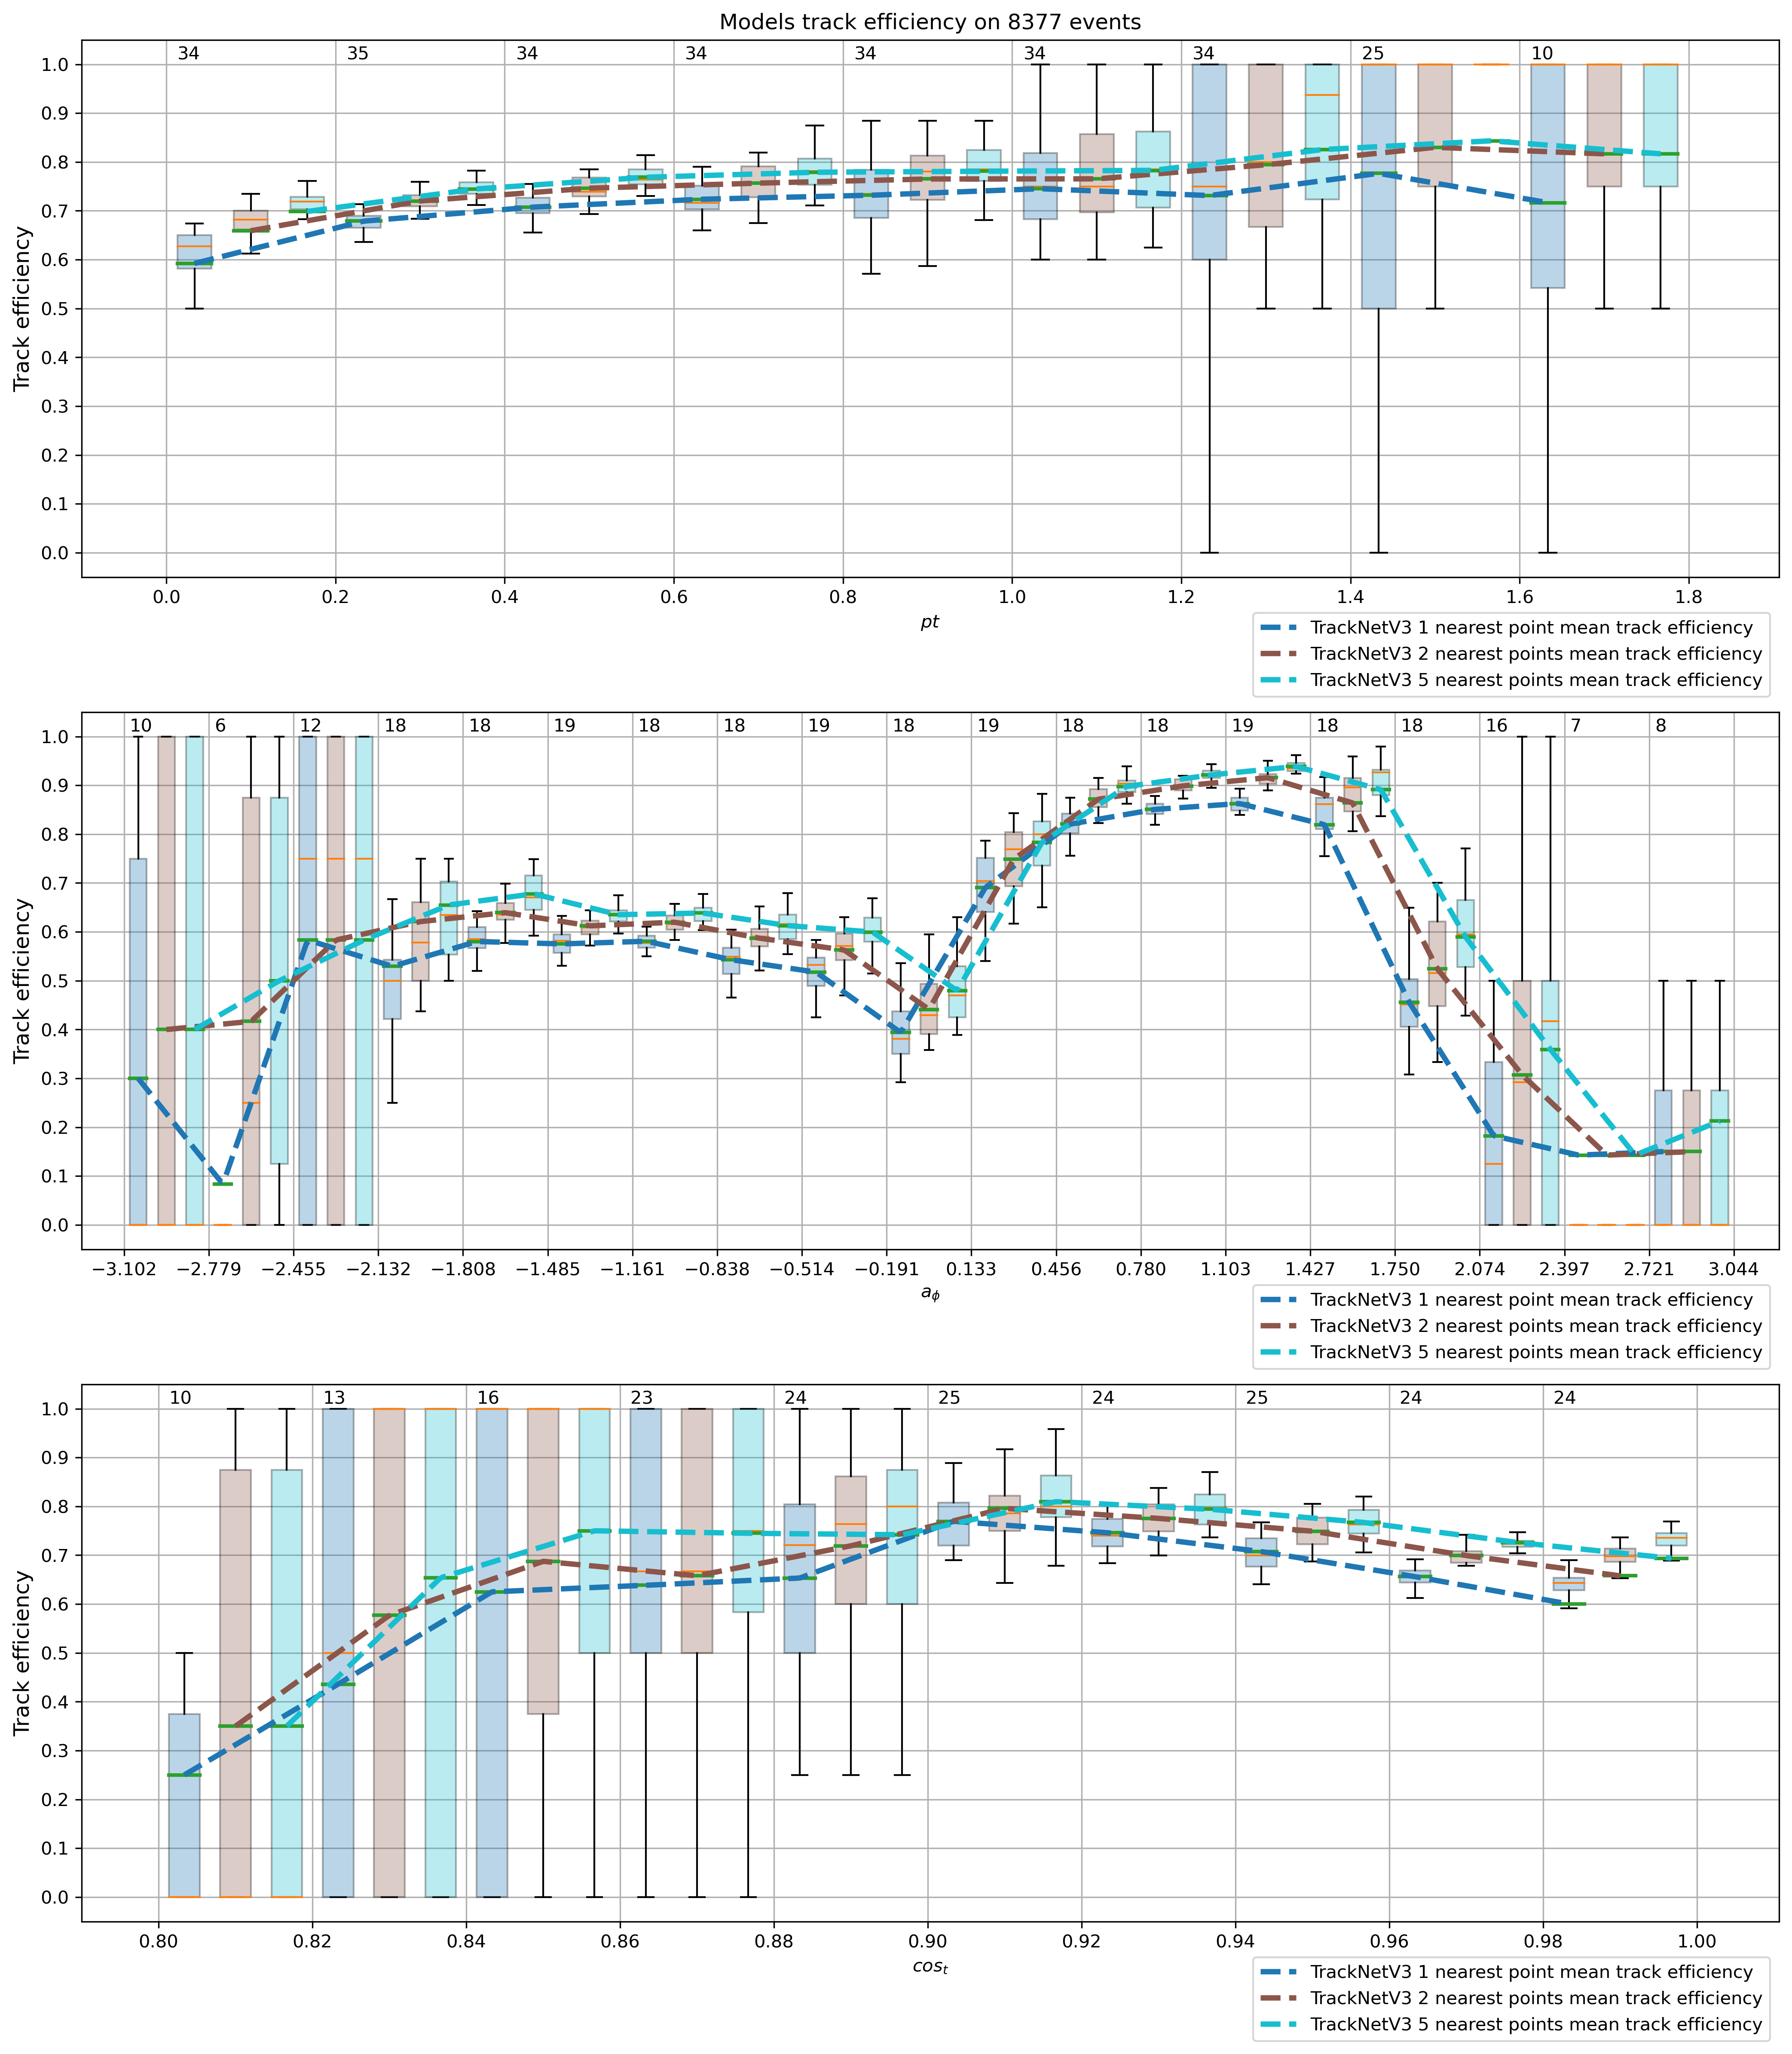

In [56]:
plot_model_results(["TrackNetV3 1 nearest point", "TrackNetV3 2 nearest points", "TrackNetV3 5 nearest points"],
                   [res_tracknet_1, res_tracknet_2, res_tracknet_20],
                   to_recall)

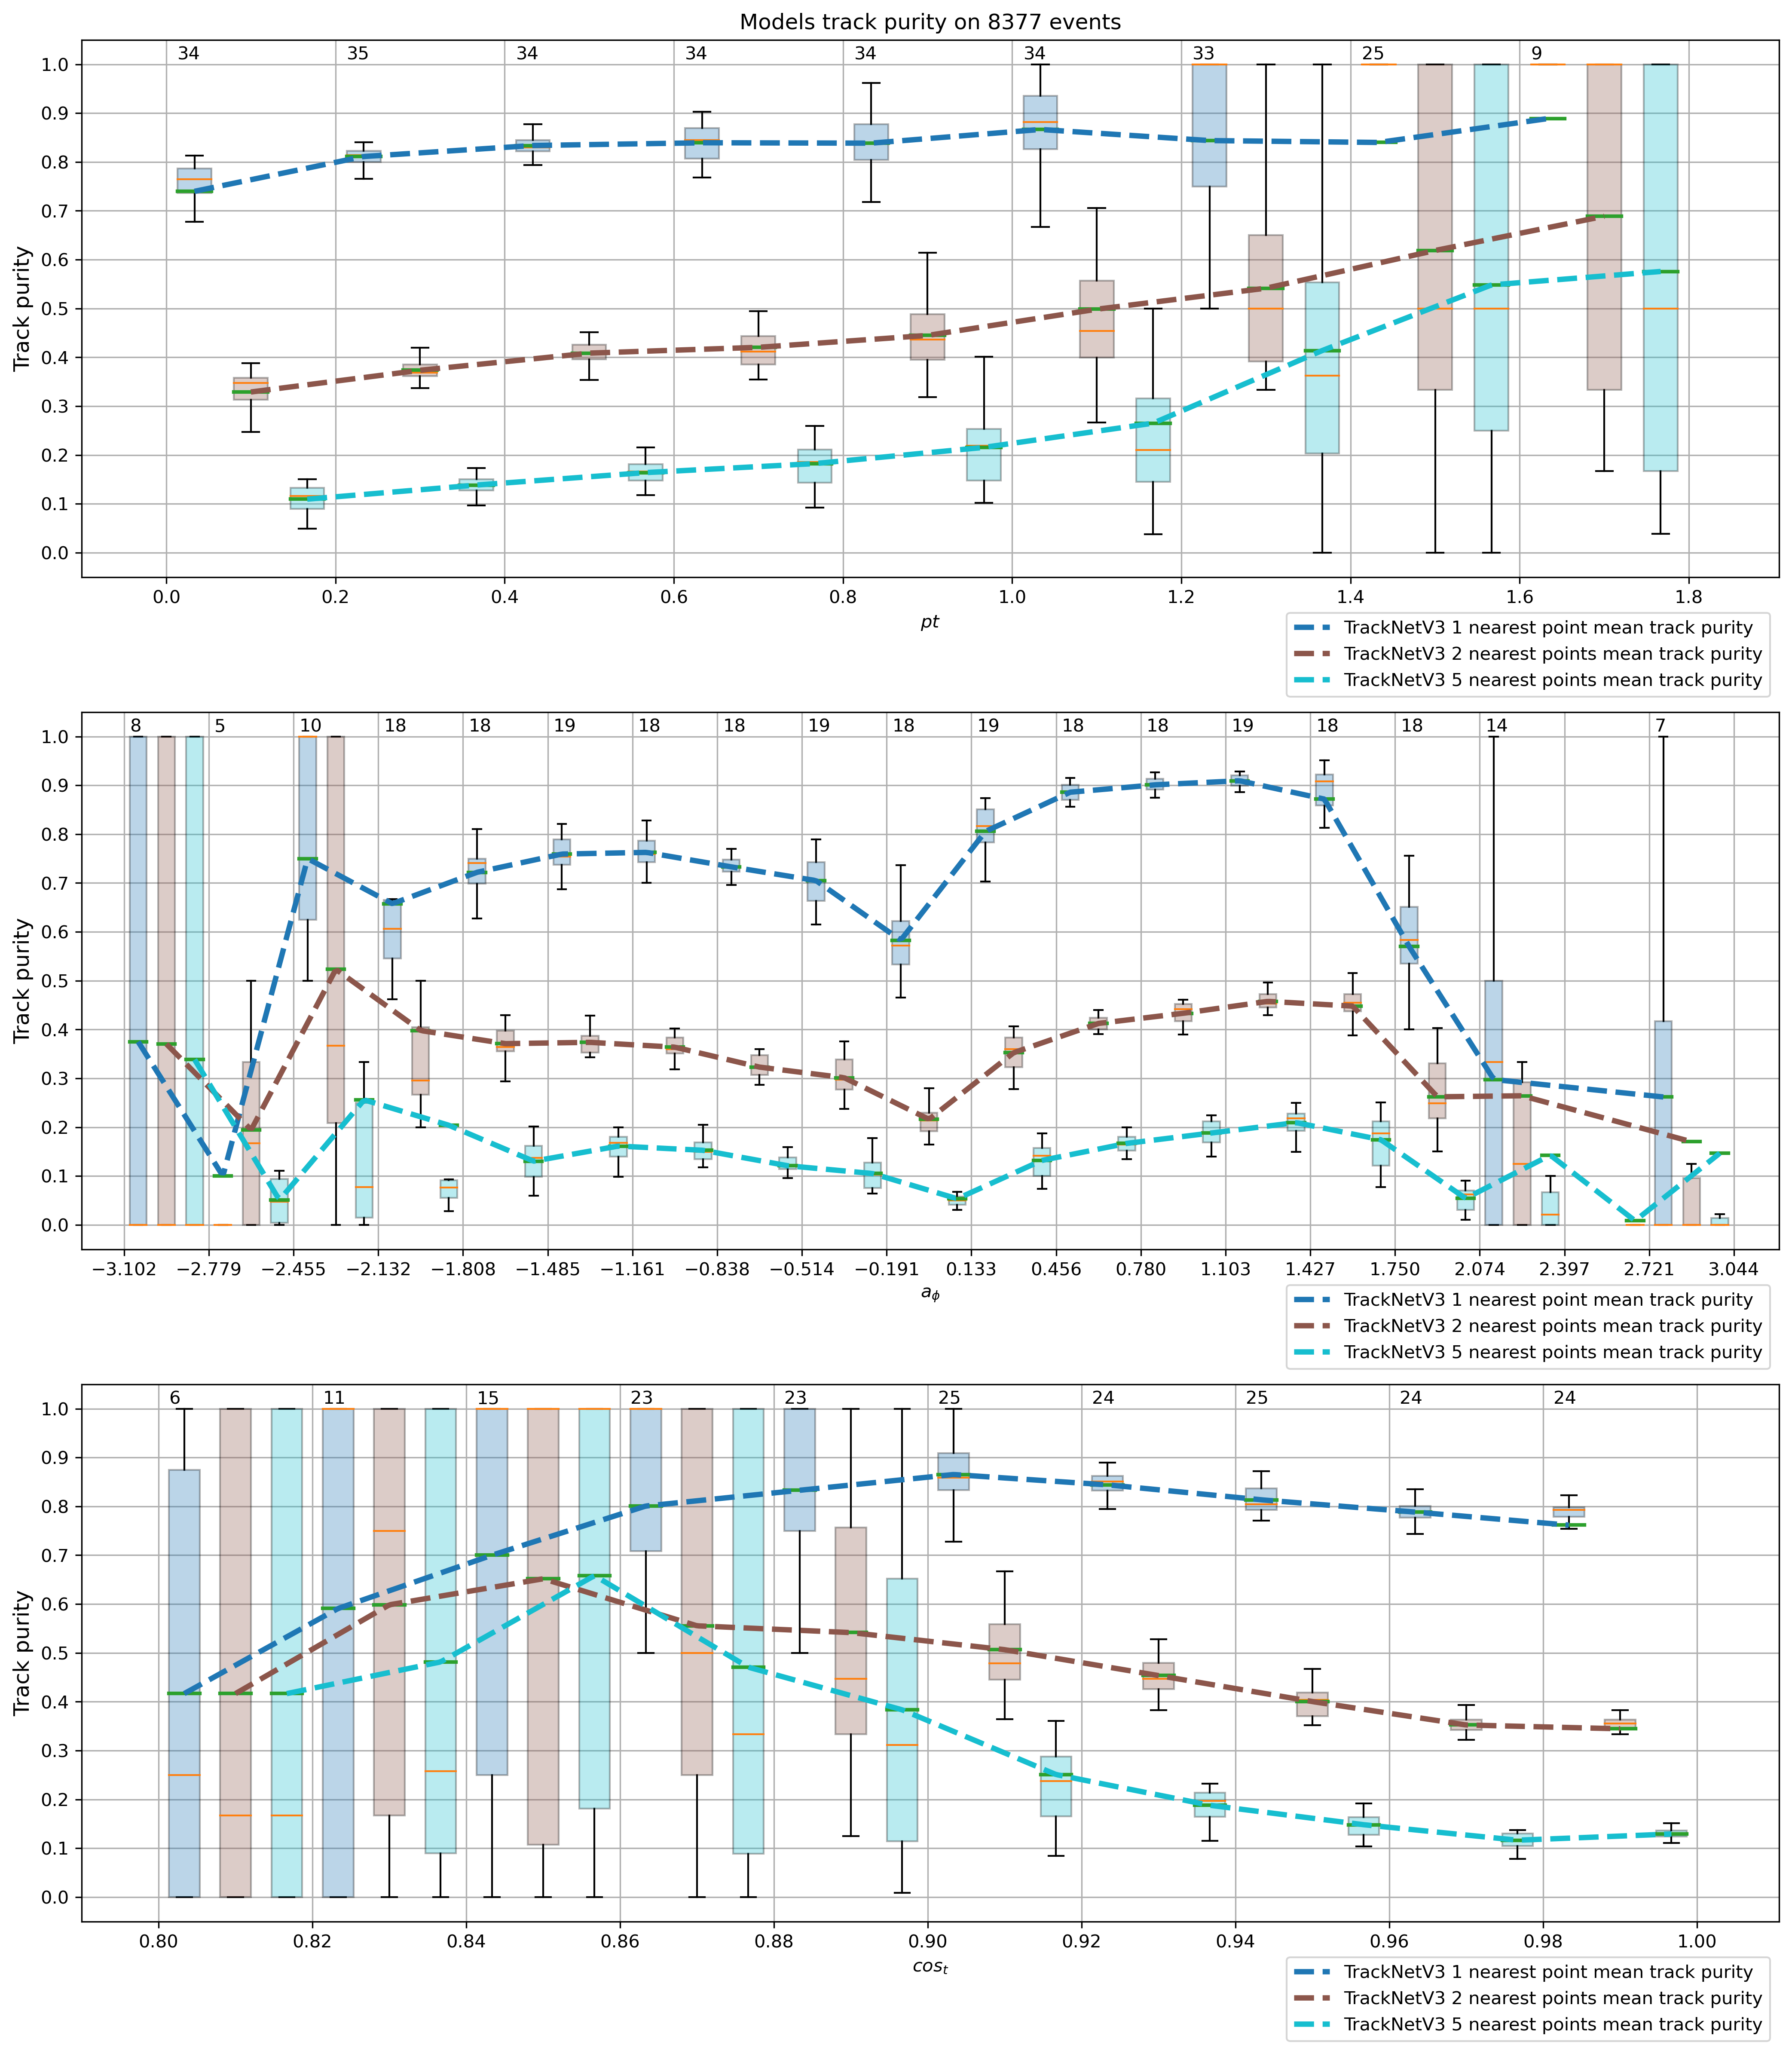

In [57]:
plot_model_results(["TrackNetV3 1 nearest point", "TrackNetV3 2 nearest points", "TrackNetV3 5 nearest points"],
                   [res_tracknet_1, res_tracknet_2, res_tracknet_20],
                   to_precision)